# Basic EDA

In [61]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import Counter
from itertools import chain
import pandas as pd
from PIL import Image
import torch
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
import torch.nn as nn
from utils import *
from tqdm import tqdm

In [62]:
# File paths for the training data
input_dir = r"C:\Users\AndrewNguyen\Desktop\CodingProject\20241E\CS4243\captcha-recognition\train"
img_paths = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.png')]

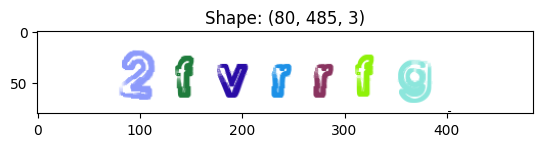

In [63]:
# show random image
img = cv2.imread(img_paths[np.random.randint(0, len(img_paths))])
plt.imshow(img)
plt.title(f'Shape: {img.shape}')
plt.show()

In [64]:
# Get list of ground-truth labels from image filenames
labels = [label_from_filepath(img_path) for img_path in img_paths]

# Get count of each unique char
char_counts = Counter(chain.from_iterable(labels))
            
# Sort by character
char_counts = sorted(char_counts.items())
# Convert items to two stand-alone lists
chars = [char_count[0] for char_count in char_counts]
counts = [char_count[1] for char_count in char_counts]
# Want first char on top, so reverse order
chars.reverse()
counts.reverse()

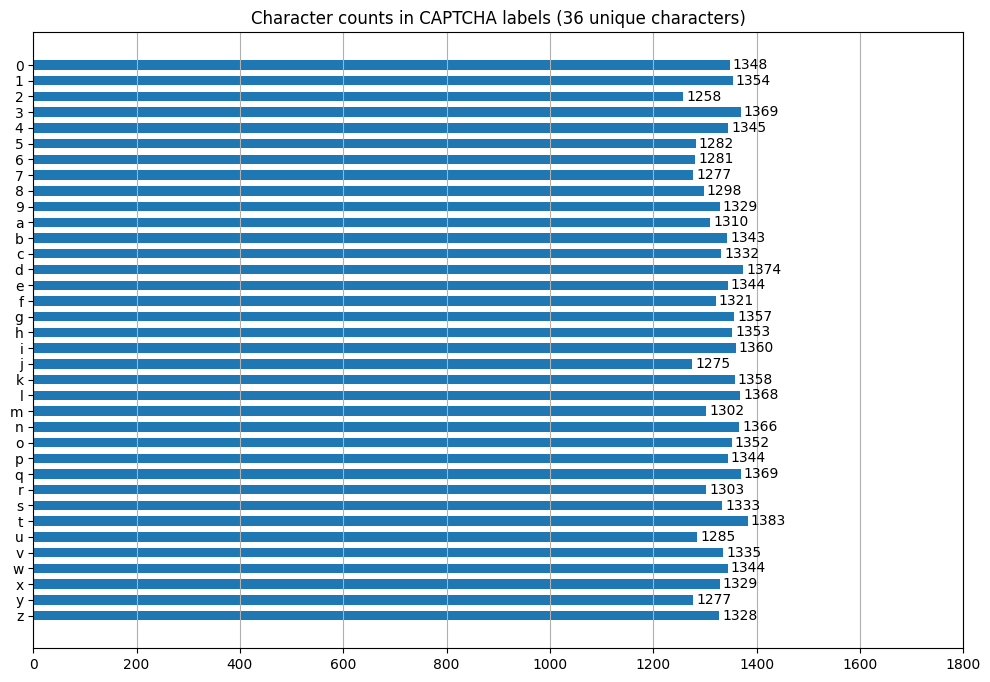

In [65]:
plt.figure(figsize=(12, 8))

bars = plt.barh(y=chars, width=counts, height=0.6)
for bar in bars:
    w = bar.get_width()
    y = bar.get_y()
    h = bar.get_height()
    plt.text(w+40, y+h/2, w, ha='center', va='center')
    
plt.xlim(0, 1800)
plt.grid(linestyle='-', axis='x')
plt.title(f'Character counts in CAPTCHA labels ({len(chars)} unique characters)')
plt.show()

In [66]:
import string

vocab = string.ascii_lowercase + string.digits
idx2char = {k:v for k,v in enumerate(vocab, start=0)}
char2idx = {v:k for k,v in idx2char.items()}
print("vocab size: ", len(vocab))
print(idx2char)
print(char2idx)

vocab size:  36
{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: '0', 27: '1', 28: '2', 29: '3', 30: '4', 31: '5', 32: '6', 33: '7', 34: '8', 35: '9'}
{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, '0': 26, '1': 27, '2': 28, '3': 29, '4': 30, '5': 31, '6': 32, '7': 33, '8': 34, '9': 35}


# Utils

In [67]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

label_from_filepath = lambda x: os.path.basename(x).split('-')[0]
label_from_filename = lambda x: x.split('-')[0]

def vertical_split(image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, width = gray_img.shape
    # Threshold the image to make sure it's binary (black and white)
    _, binary_image = cv2.threshold(gray_img, 250, 255, cv2.THRESH_BINARY)
    vertical_histogram = np.sum(binary_image == 0, axis=0)  # Sum where pixel value is 0 (foreground)
    # Find segment points (gaps) in the histogram where there are no foreground pixels
    segments = []
    start = None
    for x in range(width):
        if vertical_histogram[x] == 0:
            # If we are in a gap and previously found a start point, end the segment
            if start is not None:
                if x - start > 10:
                # Append the segmented chunk if it's larger than 10 pixels
                    segments.append(image[:, start:x])
                elif vertical_histogram[start:x].sum() > 50:
                # Maybe it's a I or L character, so we'll keep it
                    segments.append(image[:, start:x])
                start = None  # Reset start
        else:
            # If we're in a character region and start is not set, mark the start of a new chunk
            if start is None:
                start = x
    # Append the last segment if it exists
    if start is not None:
        segments.append(image[:, start:width])
    return segments

def split_connected_chars(segments):
    """
    split the largest segment into two parts if it's too wide
    """
    segment_wide = [seg.shape[1] for seg in segments]
    median_wide = np.median(segment_wide)
    # index of the widest segment
    idx = segment_wide.index(max(segment_wide))
    largest_seg = segments[idx]
    if 1.5 * median_wide < largest_seg.shape[1] < 2.5 * median_wide:
        # split the largest segment into two parts
        half_width = largest_seg.shape[1] // 2
        segments.pop(idx)
        segments.insert(idx, largest_seg[:, :half_width + 3])
        segments.insert(idx + 1, largest_seg[:, half_width - 3:])

    return segments

def crop_vertical_space(segment):
    gray = cv2.cvtColor(segment, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours and len(contours) == 1:
        x, y, w, h = cv2.boundingRect(contours[0])
        cropped_image = segment[y:y+h, x:x+w]
    else:
        # If no contours are found, the image might be empty or already cropped tightly
        cropped_image = segment
    return cropped_image


def segmenter_by_vertical_line(filepath):
    image = cv2.imread(filepath)
    segments = vertical_split(image)
    segments = [crop_vertical_space(segment) for segment in segments]
    label = label_from_filepath(filepath)
    if len(segments) == len(label) - 1:
        segments = split_connected_chars(segments)
    return segments

def plot_segments(filepath, segmenter_by_vertical_line):
    label = filepath.split('/')[-1].split('-')[0]
    objects = segmenter_by_vertical_line(filepath)
    _, ax = plt.subplots(1, len(objects), figsize=(15, 5))
    for i, obj in enumerate(objects):
        ax[i].imshow(obj)
        ax[i].axis('off')
    plt.show()
    plt.close()
    print(f'Label: {label}, Segmented: {len(objects)}')
    print('---------------------------------')

    img = cv2.imread(filepath)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def calculate_iou(box1, box2):
    """
    Calculate the Intersection-over-Union (IoU) of two bounding boxes.

    Args:
        box1, box2: Tuples of the form (x, y, w, h) representing the bounding boxes.

    Returns:
        float: IoU value between 0 and 1.
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate the (x, y)-coordinates of the intersection rectangle
    xA = max(x1, x2)
    yA = max(y1, y2)
    xB = min(x1 + w1, x2 + w2)
    yB = min(y1 + h1, y2 + h2)

    # Compute the area of intersection rectangle
    inter_area = max(0, xB - xA) * max(0, yB - yA)

    # Compute the area of both bounding boxes
    box1_area = w1 * h1
    box2_area = w2 * h2

    # Compute the area of the union
    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou

def extract_objects_from_image(filepath, white_threshold=240, pixel_step=3, min_size=10, iou_threshold=0.3):
    """
    Extract non-touching objects of different colors from an image with a white background.

    Args:
        image (np.ndarray): Input image with objects on a white background.
        white_threshold (int): Threshold to consider a pixel as "white".
        pixel_step (int): Step size for reducing the search space when finding unique colors.
        min_size (int): Minimum width and height of an object to be considered valid.
        iou_threshold (float): IoU threshold to decide if two bounding boxes overlap significantly.

    Returns:
        list: List of np.ndarray images, each containing an extracted object.
    """
    
    image = cv2.imread(filepath)
    height, width = image.shape[:2]
    extracted_images = []
    identified_boxes = []

    # Step 1: Convert the image to HSV color space for better color segmentation
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Step 2: Identify unique colors by scanning the image with a reduced search space
    unique_colors = set()
    for y in range(0, height, pixel_step):
        for x in range(0, width, pixel_step):
            pixel = image[y, x]
            if np.mean([channel for channel in pixel]) < white_threshold:  # Ignore white
                unique_colors.add(tuple(pixel))
    unique_colors = list(unique_colors)  # Convert to list for easier iteration

    # Step 3: For each unique color, create a mask, find contours, and extract objects
    for color in unique_colors:
        # Define color range with a small tolerance around the color
        lower_bound = np.array([max(0, c - 10) for c in color], dtype=np.uint8)
        upper_bound = np.array([min(255, c + 10) for c in color], dtype=np.uint8)
        mask = cv2.inRange(image, lower_bound, upper_bound)

        # Find contours in the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)

            # Step 4: Skip if object is too small
            if w < min_size or h < min_size:
                continue

            # Step 5: Check for overlapping objects using IoU and skip if overlap is significant
            overlap = False
            for prev_box in identified_boxes:
                if calculate_iou((x, y, w, h), prev_box) > iou_threshold:
                    overlap = True
                    break
            if overlap:
                continue

            # Step 6: Extract and store the object, and mark this region as identified
            extracted_image = image[y:y+h, x:x+w]
            extracted_images.append((x, extracted_image))
            identified_boxes.append((x, y, w, h))

    # Step 7: Sort extracted images by x-coordinate for left-to-right order
    extracted_images = [img for _, img in sorted(extracted_images, key=lambda item: item[0])]

    return extracted_images[1:]

# Characters Segmentation

In [68]:
train_dir = r"C:\Users\AndrewNguyen\Desktop\CodingProject\20241E\CS4243\captcha-recognition\train" # Directory storing training images
test_dir = r"C:\Users\AndrewNguyen\Desktop\CodingProject\20241E\CS4243\captcha-recognition\test" # Directory storing test images
train_data_dir = r"C:\Users\AndrewNguyen\Desktop\CodingProject\20241E\CS4243\captcha-recognition\train_segment" # Directory storing segmented images
test_data_dir = r"C:\Users\AndrewNguyen\Desktop\CodingProject\20241E\CS4243\captcha-recognition\test_segment" # Directory storing segmented images
os.makedirs(train_data_dir, exist_ok=True)
os.makedirs(test_data_dir, exist_ok=True)

In [69]:
def segment_chars(captcha_dir, save_dir):
    success = 0 # number of successful segmentations
    failures = [] # list of filenames with failed segmentations
    paths = [os.path.join(captcha_dir, f) for f in os.listdir(captcha_dir) if f.endswith('.png')]
    for file_path in tqdm(paths):
        filename = os.path.basename(file_path)
        label = filename.split('-')[0]
        objects = segmenter_by_vertical_line(file_path)
        

        if len(objects) == len(label):
            success += 1
            # save images with correct labels
            for i, obj in enumerate(objects):
                cv2.imwrite(f'{save_dir}/{label[i]}_{i}_{filename}', obj)
        else:
            objects2 = extract_objects_from_image(file_path)
            if len(objects2) == len(label):
                success += 1
                # save images with correct labels
                for i, obj in enumerate(objects2):
                    cv2.imwrite(f'{save_dir}/{label[i]}_{i}_{filename}', obj)
            else:
                failures.append(filename)

    print(f'Success: {success}, {success/len(paths)*100:.2f}%')
    return failures

In [70]:
train_failures = segment_chars(train_dir, train_data_dir)
with open('train_failed_images.txt', 'w') as f:
    for filename in train_failures:
        f.write(f'{filename}\n')

100%|██████████| 7992/7992 [03:41<00:00, 36.01it/s]

Success: 7069, 88.45%


In [71]:
train_files = os.listdir(train_data_dir)
df = pd.DataFrame(train_files, columns=['filename'])
df['label'] = df['filename'].apply(lambda x: x.split('_')[0])
df.to_csv('train.csv', index=False)

In [72]:
test_failures = segment_chars(test_dir, test_data_dir)
with open('test_failed_images.txt', 'w') as f:
    for filename in test_failures:
        f.write(f'{filename}\n')

  0%|          | 0/1999 [00:00<?, ?it/s]

100%|██████████| 1999/1999 [00:54<00:00, 36.44it/s]

Success: 1763, 88.19%


In [73]:
test_files = os.listdir(test_data_dir)
df = pd.DataFrame(test_files, columns=['filename'])
df['label'] = df['filename'].apply(lambda x: x.split('_')[0])
df.to_csv('test.csv', index=False)

# Create Dataset and Data Loaders

In [74]:
transform = transforms.Compose([
    transforms.Grayscale(), # 3-band to 1-band
    transforms.Resize((28, 28)), # average size of each char image
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [75]:
class CharsDataset(Dataset):
    '''
    Custom PyTorch Dataset to load in individual character images segmented
    from CAPTCHA images
    '''
    def __init__(self, annotations_path, root_dir):
        self.annotations = pd.read_csv(annotations_path)
        self.root_dir = root_dir

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        img = Image.open(img_path)
        label = self.annotations.iloc[index, 1]
        y_label = torch.tensor(char2idx[label])
        img = transform(img)

        return (img, y_label)

In [76]:
train_set = CharsDataset('train.csv', train_data_dir)
test_set = CharsDataset('test.csv', test_data_dir)

In [77]:
len(train_set), len(test_set)

(42210, 10552)

Text(0.5, 1.0, 'Label: r')

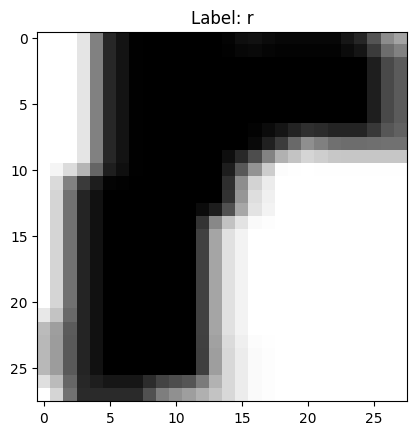

In [78]:
# show random image from train set
img, label = train_set[np.random.randint(0, len(train_set))]
img = img.squeeze().numpy()
plt.imshow(img, cmap='gray')
plt.title(f'Label: {idx2char[label.item()]}')

In [79]:
train_loader = DataLoader(dataset=train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(dataset=test_set, batch_size=128, shuffle=True)

# CNN Model

In [80]:
import torch.nn.functional as F
class LeNet(nn.Module):
    '''
    Baseline LeNet-5 model for CAPTCHA character recognition.
    '''
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 36)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [81]:
class MyCNN(nn.Module):
    '''
    Custom CNN model for CAPTCHA character recognition.
    '''
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 16, 3, padding=2)
        self.fc1   = nn.Linear(16 * 7 * 7, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 36)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 16 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [82]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
# model = LeNet().to(device)
model = MyCNN().to(device)

# Train Model

In [83]:
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 5

In [84]:
for epoch in range(epochs):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)
        output = model(data)
        loss = criterion(output, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 200 == 0:
            print(f'epoch {epoch} batch {batch_idx} loss {loss.item()}')

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, targets in val_loader:
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            _, predictions = scores.max(1)
            correct += (predictions == targets).sum()
            total += predictions.size(0)

        print(f'Test accuracy {correct/total}')

epoch 0 batch 0 loss 3.5820741653442383
epoch 0 batch 200 loss 2.0471510887145996
Test accuracy 0.5924943089485168
epoch 1 batch 0 loss 1.5912264585494995
epoch 1 batch 200 loss 1.1645071506500244
Test accuracy 0.6735215783119202
epoch 2 batch 0 loss 1.2645858526229858
epoch 2 batch 200 loss 1.0979238748550415
Test accuracy 0.7158832550048828
epoch 3 batch 0 loss 1.0100467205047607
epoch 3 batch 200 loss 1.0685571432113647
Test accuracy 0.7347422242164612
epoch 4 batch 0 loss 0.7123925089836121
epoch 4 batch 200 loss 0.6076580286026001
Test accuracy 0.7475360035896301


In [85]:
# Save state dictionary of trained model
torch.save(model.state_dict(), 'model_state_dict.pt')

# Evaluate Model

In [86]:
def predict(file_path, plot_segments=False):
    '''Use trained model to make a prediction on a CAPTCHA image'''
    # Segment CAPTCHA image into characters
    segmented_chars = segmenter_by_vertical_line(file_path)

    # Predict on each character
    predictions = []
    for x in segmented_chars:
        x = Image.fromarray(x) # to PIL image
        x = transform(x) # Apply Dataset transformations
        x = x.to(device)
        prediction = model(x.unsqueeze(0))
        y_hat = torch.max(prediction, 1)[1].data.squeeze()
        # Convert integer prediction to character using label dict
        y_hat = idx2char[y_hat.item()]
        predictions.append(y_hat)

    if plot_segments:
        _, axs = plt.subplots(1, len(segmented_chars), figsize=(15, 5))
        for i, ax in enumerate(axs):
            ax.imshow(segmented_chars[i])
            ax.set_title(f'Prediction: {predictions[i]}')
            ax.axis('off')
        plt.show()

        img = cv2.imread(file_path)
        plt.imshow(img)
        plt.title(f'Original Label: {label_from_filepath(file_path)}')
        plt.axis('off')
        plt.show()

    return "".join(predictions)

In [88]:
test_files = os.listdir(r"C:\Users\AndrewNguyen\Desktop\CodingProject\20241E\CS4243\captcha-recognition\test")

bju19ad-0.png
C:\Users\AndrewNguyen\Desktop\CodingProject\20241E\CS4243\captcha-recognition\test\\cxjpkyui-0.png


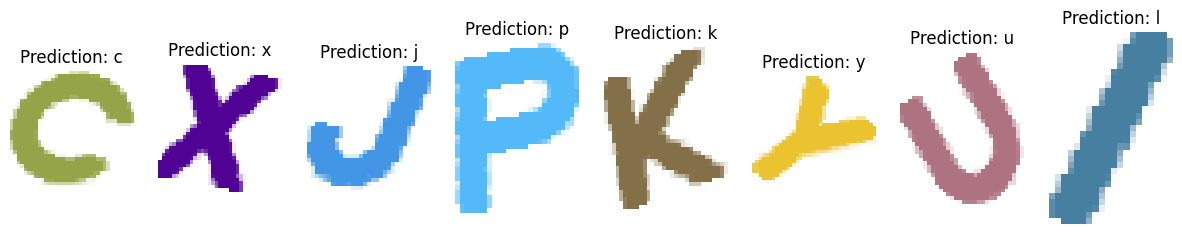

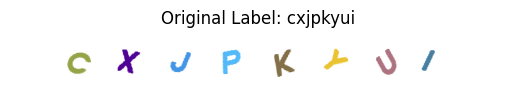

'cxjpkyul'

In [100]:
file = r"C:\Users\AndrewNguyen\Desktop\CodingProject\20241E\CS4243\captcha-recognition\test\\" + str(test_files[np.random.randint(0, len(test_files))])
print(test_files[np.random.randint(0, len(test_files))])
print(file)
# file = r"C:\Users\AndrewNguyen\Desktop\CodingProject\20241E\CS4243\captcha-recognition\test\0si2gw-0.png"
# file = r"C:/Users/AndrewNguyen/Desktop/CodingProject/20241E/CS4243/captcha-recognition\test\0si2gw-0.png"
predict(file, plot_segments=True)

In [101]:
correct = 0
for file in tqdm(test_files):
    pred = predict(r"C:\Users\AndrewNguyen\Desktop\CodingProject\20241E\CS4243\captcha-recognition\test\\" + file)
    if pred == label_from_filepath(file):
        correct += 1

print(f'Captcha Accuracy: {correct/len(test_files)*100:.2f}%')


  0%|          | 0/1999 [00:00<?, ?it/s]

100%|██████████| 1999/1999 [00:39<00:00, 50.40it/s]

Captcha Accuracy: 26.86%
